<a href="https://colab.research.google.com/github/rezzzq/colab-notebook/blob/main/Steel_Design.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source Code

## Install packages

In [ ]:
!pip install sectionproperties==2.1.5

In [ ]:
from __future__ import annotations

##Functions

### Calcuate Local Slenderness Limit

In [ ]:
from enum import Enum, auto
from collections import namedtuple
from dataclasses import dataclass

class PlateType(Enum):
  FLAT = "FLAT"
  HOLLOW = "HOLLOW"

class PlateEdgeSupportType(Enum):
  ONE = "ONE"
  BOTH = "BOTH"

class PlateStressType(Enum):
  UNIFORM = "UNIFORM"
  NON_UNIFORM = "NON_UNIFORM"

class ResidualStressType(Enum):
  SR = "SR"
  HR = "HR"
  LW = "LW"
  CF = "CF"
  HW = "HW"

@dataclass
class SlendernessLimit:
  lambda_ep: float
  lambda_ey: float
  lambda_ed: float

def local_slenderness_limit(plate_type, res_stress_type, support_type=None, stress_type=None):

  match (plate_type, support_type):
    case (PlateType.FLAT, PlateEdgeSupportType.ONE):
      match stress_type:
        case PlateStressType.UNIFORM:
          match res_stress_type:
            case ResidualStressType.SR:
              limit = SlendernessLimit(10,16,35)
            case ResidualStressType.HR:
              limit = SlendernessLimit(9,16,35)
            case ResidualStressType.LW:
              limit = SlendernessLimit(8,15,35)
            case ResidualStressType.CF:
              limit = SlendernessLimit(8,15,35)
            case ResidualStressType.HW:
              limit = SlendernessLimit(8,14,35)
            case _:
              print("Incorrect plate residual stress type")
              return None
        case PlateStressType.NON_UNIFORM:
          match res_stress_type:
            case ResidualStressType.SR:
              limit = SlendernessLimit(10,25,None)
            case ResidualStressType.HR:
              limit = SlendernessLimit(9,25,None)
            case ResidualStressType.LW:
              limit = SlendernessLimit(8,22,None)
            case ResidualStressType.CF:
              limit = SlendernessLimit(8,22,None)
            case ResidualStressType.HW:
              limit = SlendernessLimit(8,22,None)
            case _:
              print("Incorrect plate residual stress type")
              return None
        case _:
              print("Incorrect plate stress type")
              return None

    case (PlateType.FLAT, PlateEdgeSupportType.BOTH):
      match stress_type:
        case PlateStressType.UNIFORM:
          match res_stress_type:
            case ResidualStressType.SR:
              limit = SlendernessLimit(30,45,90)
            case ResidualStressType.HR:
              limit = SlendernessLimit(30,45,90)
            case ResidualStressType.LW:
              limit = SlendernessLimit(30,40,90)
            case ResidualStressType.CF:
              limit = SlendernessLimit(30,40,90)
            case ResidualStressType.HW:
              limit = SlendernessLimit(30,35,90)
            case _:
              print("Incorrect plate residual stress type")
              return None
        case PlateStressType.NON_UNIFORM:
                limit = SlendernessLimit(82,115,None)
        case _:
          print("Incorrect plate stress type")
          return None
    case (PlateType.HOLLOW, None):
          match res_stress_type:
              case ResidualStressType.SR:
                limit = SlendernessLimit(50,120,None)
              case ResidualStressType.HR:
                limit = SlendernessLimit(50,120,None)
              case ResidualStressType.LW:
                limit = SlendernessLimit(42,120,None)
              case ResidualStressType.CF:
                limit = SlendernessLimit(50,120,None)
              case ResidualStressType.HW:
                limit = SlendernessLimit(42,120,None)
              case _:
                print("Incorrect plate residual stress type")
                return None
    case _:
      print("Incorrect plate type and/or plate edges support type")
      return None


  return limit

### Calculate Local Slenderness

In [ ]:
import math

def flat_section_local_slenderness(b,t,fy):
  lambda_e = b/t * math.sqrt(fy/250)
  return lambda_e

def hollow_section_local_slenderness(do, t, fy):
  lambda_s = do/t * fy/250
  return lambda_s

In [ ]:
def lambda_ratio(lambda_e, lambda_ey):
  return lambda_e/lambda_ey

def compact_type(lambda_e, lambda_ep, lambda_ey):
  if lambda_e <= lambda_ep:
    compact_type = CompactType.COMPACT
  elif lambda_e <= lambda_ey and lambda_e > lambda_ep:
    compact_type = CompactType.NON_COMPACT
  else:
    compact_type = CompactType.SLENDER
  return compact_type

def calc_lambda_e(plate_type, b, t, fy):
  match plate_type:
    case PlateType.HOLLOW:
      return hollow_section_local_slenderness(b, t, fy)
    case _:
      return flat_section_local_slenderness(b, t, fy)

### Calculate Ze

In [ ]:
def calc_Ze(plate: Plate, elastic_section_mod, plastic_section_mod):
  Zc = min(plastic_section_mod, 1.5*elastic_section_mod)
  match plate.compact_type:
    case CompactType.COMPACT:
      Ze = Zc
    case CompactType.NON_COMPACT:
      Ze = elastic_section_mod + ((plate.lambda_limit.lambda_ey - plate.lambda_e)/(plate.lambda_limit.lambda_ey - plate.lambda_limit.lambda_ep))*Zc
    case _:
      match plate.plate_type:
        case PlateType.FLAT:
          if plate.stress_type == PlateStressType.UNIFORM:
            Ze = elastic_section_mod*(plate.lambda_limit.lambda_ey/plate.lambda_e)
          else:
            Ze = elastic_section_mod*(plate.lambda_limit.lambda_ey/plate.lambda_e)**2
        case PlateType.HOLLOW:
          Ze1 = elastic_section_mod*math.sqrt(plate.lambda_limit.lambda_ey/plate.lambda_e)
          Ze2 = elastic_section_mod*(2*plate.lambda_limit.lambda_ey/plate.lambda_e)**2
          Ze = min(Ze1, Ze2)
        case _:
          print("Unhandled case")
          return None
  return Ze


### Calculate Section Bending Capacity

In [ ]:
def calc_Ms(Ze, fy):
  return fy*Ze

### Calculate Member Bending Capacity

#### Type of restraint

In [ ]:
class RestraintType(Enum):
  FF = auto()
  FL = auto()
  LL = auto()
  FU = auto()
  FP = auto()
  PL = auto()
  PU = auto()
  PP = auto()

class EndRotationalRestraint(Enum):
  NONE = auto()
  ONE = auto()
  BOTH = auto()

#### Calculate Effective Length

In [ ]:
def twist_restraint_factor(rest_type: RestraintType, d1, tf, tw, nw, length):
  if tf is None or tw is None or tw is None:
    return 1.0


  match rest_type:
    case RestraintType.FF | RestraintType.FL | RestraintType.LL | RestraintType.FU:
      kt = 1.0
    case RestraintType.FP | RestraintType.PL | RestraintType.PU:
      kt = 1 + (((d1/length) * (tf/(2*tw))**3) / nw)
    case RestraintType.PP:
      kt = 1 + ((2*(d1/length) * (tf/(2*tw)**3)) / nw)
    case _:
      raise ValueError(f"Restraint Type {rest_type} is unknown")
  return kt

In [ ]:
def load_height_factor(rest_type: RestraintType, load_height_top=True, load_pos_end=False, grav=True):
  if not grav:
    return 1.0

  if not load_height_top:
    return 1.0

  if load_pos_end:
    match rest_type:
      case RestraintType.FF | RestraintType.FP | RestraintType.FL | RestraintType.PP | RestraintType.PL | RestraintType.LL:
        return 1.0
      case RestraintType.FU | RestraintType.PU:
        return 2.0
      case _:
        raise ValueError(f"Restraint Type {rest_type} is unknown")
  else:
    match rest_type:
      case RestraintType.FF | RestraintType.FP | RestraintType.FL | RestraintType.PP | RestraintType.PL | RestraintType.LL:
        return 1.4
      case RestraintType.FU | RestraintType.PU:
        return 2.0
      case _:
        raise ValueError(f"Restraint Type {rest_type} is unknown")



In [ ]:
def rotation_restraint_factor(rest_type: RestraintType, rotation_restraint: EndRotationalRestraint = EndRotationalRestraint.NONE):
  match rest_type:
    case RestraintType.FF | RestraintType.FP | RestraintType.PP:
      if rotation_restraint == EndRotationalRestraint.ONE:
        return 0.85
      elif rotation_restraint == EndRotationalRestraint.BOTH:
        return 0.7
      else:
        return 1.0
    case _:
      return 1.0

In [ ]:
def effective_length(kt, kl, kr, length):
  return kt*kl*kr*length

#### Calculate Mb

In [ ]:
def alpha_m(moment_dist_type: int, cantilever=False, beta_m=None, a=None, length=None):
  if cantilever:
    match moment_dist_type:
      case 1:
        return 0.25
      case 2:
        return 1.25
      case 3:
        return 2.25
      case _:
        raise ValueError("Moment Modification number should be from 1-3 based on the row number in table 5.6.2 AS 4100:1998")

  match moment_dist_type:
    case 1:
      if beta_m is None:
        raise ValueError("beta_m is required")
      elif beta_m  <= 0.6 and beta_m >= -1:
        return 1.75 + 1.05*beta_m + 0.3*beta_m**2
      elif beta_m <= 1 and beta_m > 0.6:
        return 2.5
      else:
        raise ValueError("beta_m is out of range")
    case 2:
      if a is None or length is None:
        raise ValueError("a and length is required")
      elif 2*a/length <= 1 and 2*a/length >= 0:
        return 1 + 0.35 * (1 - (2*a/length))**2
      else:
        raise ValueError("2a/l is out of range")
    case 3:
      if a is None or length is None:
        raise ValueError("a and length is required")
      elif 2*a/length <= 1 and 2*a/length >= 0:
        return 1.35 + 0.4 * ((2*a/length))**2
      else:
        raise ValueError("2a/l is out of range")
    case 4:
      if beta_m is None:
        raise ValueError("beta_m is required")
      elif beta_m  <= 0.9 and beta_m >= 0:
        return 1.35 + 0.15*beta_m
      elif beta_m <= 1 and beta_m >= 0.9:
        return -1.2 + 3*beta_m
      else:
        raise ValueError("beta_m is out of range")
    case 5:
      if beta_m is None:
        raise ValueError("beta_m is required")
      elif beta_m  <= 1 and beta_m >= 0:
        return 1.35 + 0.36*beta_m
      else:
        raise ValueError("beta_m is out of range")
    case 6:
      if beta_m is None:
        raise ValueError("beta_m is required")
      elif beta_m  <= 0.7 and beta_m >= 0:
        return 1.13 + 0.1*beta_m
      elif beta_m <= 1 and beta_m >= 0.7:
        return -1.25 + 3.5*beta_m
      else:
        raise ValueError("beta_m is out of range")
    case 7:
      if beta_m is None:
        raise ValueError("beta_m is required")
      elif beta_m  <= 0.75 and beta_m >= 0:
        return 1.13 + 0.12*beta_m
      elif beta_m <= 1 and beta_m >= 0.75:
        return -2.38 + 4.8*beta_m
      else:
        raise ValueError("beta_m is out of range")
    case 8:
      return 1.0
    case 9:
      return 1.75
    case 10:
      return 2.5
    case _:
      raise ValueError("Moment Modification number should be from 1-10 based on the row number in table 5.6.1 AS 4100:1998")

In [ ]:
def Mo(E, G, I_minor, J, Iw, beta, length_eff):
  Py = math.pi**2*E*I_minor/length_eff**2
  Pw = math.pi**2*E*Iw/length_eff**2

  return math.sqrt(Py)*(math.sqrt(G*J + Pw + (beta**2 / 4)*Py)) + beta*math.sqrt(Py)

In [ ]:
def alpha_s(Ms, Mo):
  return 0.6*(math.sqrt((Ms/Mo)**2 + 3) - (Ms/Mo))

In [ ]:
def Mb(alfa_m, alfa_s, Ms):
  return min(Ms, alfa_m*alfa_s*Ms)

### Calculate Section Compression Capacity

#### Calculate Ns

In [ ]:
def calc_effective_area(plate_list: list[Plate]):
  area_eff = 0
  for plate in plate_list:
    be = min(plate.b, plate.b * plate.lambda_limit.lambda_ey / plate.lambda_e)
    area_eff += be*plate.t
  return area_eff


In [ ]:
def calc_kf(area_eff, area_gross):
  return min(1,area_eff/area_gross)

def calc_Ns(kf, area_net, fy):
  return kf*area_net*fy

### Calculate Member Compression Capacity

In [ ]:
def compression_eff_length(ke, length):
  return ke*length

def calc_lambda_n(length_eff,r,kf,fy):
  return (length_eff/r) * math.sqrt(kf) * math.sqrt(fy/250)

def calc_alpha_a(lambda_n):
  return (2100 * (lambda_n - 13.5))/(lambda_n**2 - 15.3*lambda_n + 2050)

def calc_lambda_comp(lambda_n, alpha_a, alpha_b):
  return lambda_n + alpha_a*alpha_b

def calc_eta(lambda_comp):
  return max(0, 0.00326*(lambda_comp-13.5))

def calc_ksi(lambda_comp, eta):
  return ((lambda_comp/90)**2 + 1 + eta) / (2*(lambda_comp/90)**2)

def calc_alpha_c(ksi, lambda_comp):
  return ksi * (1 - math.sqrt(1 - (90/(ksi*lambda_comp))**2))

def calc_Nc(alpha_c, Ns):
  return min(Ns, alpha_c*Ns)

### Calculate Tension Capacity

In [ ]:
class TensionConfigCase(Enum):
  Ia = auto()
  Ib = auto()
  IIa = auto()
  IIb = auto()
  III = auto()
  IV = auto()
  V = auto()
  VI = auto()
  VII = auto()

In [ ]:
def calc_tension_net_area(area_gross, area_holes):
  return area_gross - area_holes

def calc_kt(tension_config_case: TensionConfigCase):
  match tension_config_case:
    case TensionConfigCase.Ia:
      return 0.75
    case TensionConfigCase.Ib:
      return 0.85
    case TensionConfigCase.IIa:
      return 0.75
    case TensionConfigCase.IIb:
      return 0.85
    case TensionConfigCase.III:
      return 0.85
    case TensionConfigCase.IV:
      return 0.9
    case TensionConfigCase.V | TensionConfigCase.VI | TensionConfigCase.VII:
      return 1.0
    case _:
      raise ValueError("Chose case from roman numeral Ia, Ib, IIa, IIb, III, IV, V, VI, VII from table 7.3.2 AS4100:1998")


def calc_Nt(area_gross, area_net, kt, fy, fu):
  return min(area_gross*fy, 0.85*kt*area_net,fu)

### Combine Actions LRFD Design

In [ ]:
def calc_axial_section_capacity_ratio(N_str, Ns, Nt, phi):
  ratio_N = 0
  if N_str >= 0: #tension
    ratio_N = N_str/(phi*Nt)
  elif N_str < 0: #compression
    ratio_N = abs(N_str)/(phi*Ns)
  return ratio_N

In [ ]:
def calc_bending_section_capacity_ratio(N_str, M_str, Ns, Nt, Ms_pos, Ms_neg, phi):
  ratio_M = 0

  if M_str >= 0: #positive bending
    ratio_M = M_str/(phi*Ms_pos)
  elif M_str < 0: #negative bending
    ratio_M = abs(M_str)/(phi*Ms_neg)

  return ratio_M

In [ ]:
def calc_biaxial_section_capacity_ratio(ratio_N, ratio_Mx, ratio_My):
  return ratio_N + ratio_Mx + ratio_My

In [ ]:
def calc_axial_member_capacity_ratio(N_str, Nc, phi):
  ratio_N = 0
  if N_str < 0: #compression
    ratio_N = abs(N_str)/(phi*Nc)
  return ratio_N


In [ ]:
def calc_section_bending_axial_factor(N_str, Ns, Nt, phi):
  if N_str >= 0: #tension
    factor = 1 - (N_str/(phi*Nt))
  else: #compression
    factor = 1 - (abs(N_str)/(phi*Ns))

  return max(0, factor)

In [ ]:
def calc_Mr(N_str, sect_bending_axial_factor, Ms, phi):
  return Ms*sect_bending_axial_factor

In [ ]:
def calc_member_in_plane_bending_axial_factor(N_str, Nc, Nt, phi):
  if N_str >= 0: #tension
    factor = 1 - N_str/(phi*Nt)
  else: #compression
    factor = 1 - (abs(N_str)/(phi*Nc))

  return max(0,factor)

In [ ]:
def calc_Mi(Ms,member_in_plane_bending_axial_factor):
  return Ms*member_in_plane_bending_axial_factor

In [ ]:
def calc_member_in_plane_capacity_ratio(M_str, Mi_pos, Mi_neg, phi):
  if Mi_pos == 0 or Mi_neg == 0:
    return float('inf')
  if M_str >= 0: #positive bending
    return M_str/(phi*Mi_pos)
  else: #negative bending
    return abs(M_str)/(phi*abs(Mi_neg))

In [ ]:
def calc_member_out_plane_bending_axial_factor(N_str, Ncy, Nt, phi):
  if N_str >= 0: #tension
    factor = 1 + N_str/(phi*Nt)
  else: #compression
    factor = 1 - (abs(N_str)/(phi*Ncy))

  return max(0, factor)

In [ ]:
def calc_Mox(N_str, member_bending_axial_factor, Mbx, Mrx, phi):
  return min(Mrx, Mbx*member_bending_axial_factor)



In [ ]:
def calc_member_out_plane_capacity_ratio(Mx_str, Mox_pos, Mox_neg, phi):
  if Mox_pos == 0 or Mox_neg == 0:
    return float('inf')
  if Mx_str >= 0: #positive bending
    return Mx_str/(phi*Mox_pos)
  else: #negative bending
    return abs(Mx_str)/(phi*abs(Mox_neg))

In [ ]:
def calc_Mtx(Mrx, Mox):
  return min(Mrx, Mox)

In [ ]:
def calc_Mcx(Mix, Mox):
  return min(Mix, Mox)

In [ ]:
def calc_biaxial_member_capacity_Mx_ratio(N_str, Mx_str, Mtx_pos, Mtx_neg, Mcx_pos, Mcx_neg, phi):
  ratio_Mx = 0

  if Mtx_pos == 0 or Mtx_neg == 0 or Mcx_pos == 0 or Mcx_neg == 0:
    return float('inf')

  if N_str >= 0: #tension
    if Mx_str >= 0:
      ratio_Mx = (Mx_str/(phi*Mtx_pos))**1.4
    elif Mx_str < 0:
      ratio_Mx = (abs(Mx_str)/(phi*abs(Mtx_neg)))**1.4

  elif N_str < 0: #compression
    if Mx_str >= 0:
      ratio_Mx = (Mx_str/(phi*Mcx_pos))**1.4
    elif Mx_str < 0:
      ratio_Mx = (abs(Mx_str)/(phi*abs(Mcx_neg)))**1.4

  return ratio_Mx

In [ ]:
def calc_biaxial_member_capacity_My_ratio(N_str, My_str, Mry_pos, Mry_neg, Miy_pos, Miy_neg, phi):
  ratio_My = 0

  if Mry_pos == 0 or Mry_neg == 0 or Miy_pos == 0 or Miy_neg == 0:
    return float('inf')

  if N_str >= 0: #tension
    if My_str >= 0:
      ratio_My = (My_str/(phi*Mry_pos))**1.4
    elif My_str < 0:
      ratio_My = (abs(My_str)/(phi*abs(Mry_neg)))**1.4

  elif N_str < 0: #compression
    if My_str >= 0:
      ratio_My = (My_str/(phi*Miy_pos))**1.4
    elif My_str < 0:
      ratio_My = (abs(My_str)/(phi*abs(Miy_neg)))**1.4

  return ratio_My

In [ ]:
def calc_biaxial_member_capacity_ratio(ratio_Mx, ratio_My):
  return ratio_Mx + ratio_My


## Classes

### SteelMaterial Class

In [ ]:
from sectionproperties.pre.pre import Material

@dataclass(frozen=True)
class SteelMaterial(Material):
  fu: float = None
  yield_strength: float = 240
  elastic_modulus: float = 200e3
  poissons_ratio: float = 0.3
  density: float = 7850e-3
  color: str = "cyan"

### Plate Class

In [ ]:
from dataclasses import dataclass
from typing import Optional
from enum import Enum, auto

class CompactType(Enum):
  COMPACT = "COMPACT"
  NON_COMPACT = "NON_COMPACT"
  SLENDER = "SLENDER"


@dataclass
class Plate:
  b:float
  t:float
  material: SteelMaterial
  plate_type: PlateType
  res_stress_type: ResidualStressType
  support_type: Optional[PlateEdgeSupportType] = None
  stress_type: Optional[PlateStressType] = None

  @property
  def lambda_e(self):
    return calc_lambda_e(self.plate_type,self.b,self.t,self.material.yield_strength)

  @property
  def lambda_limit(self):
    return local_slenderness_limit(self.plate_type, self.res_stress_type, self.support_type, self.stress_type)

  @property
  def lambda_ratio(self):
    return lambda_ratio(self.lambda_e, self.lambda_limit.lambda_ey)

  @property
  def compact_type(self):
    return compact_type(self.lambda_e, self.lambda_limit.lambda_ep, self.lambda_limit.lambda_ey)




def section_slenderness(plate_list: list[Plate], fy):
  if len(plate_list) != 1 and plate_list[0].plate_type == PlateType.HOLLOW:
    raise ValueError("hollow plate can only have 1 element in the list")

  max_ratio = max(plate.lambda_ratio for plate in plate_list)

  for plate in plate_list:
    if plate.lambda_ratio == max_ratio:
      return plate




### DesignSection Class

In [ ]:
from sectionproperties.analysis.section import Section

@dataclass
class DesignSection:
  name: str
  section: Section
  material: SteelMaterial
  plates_x: list[Plate]
  plates_y: list[Plate]
  area_holes: float = 0
  tension_config_case: TensionConfigCase = TensionConfigCase.VI


  @property
  def fy(self):
    return self.material.yield_strength

  @property
  def fu(self):
    return self.material.fu

  @property
  def E(self):
    return self.material.elastic_modulus

  @property
  def G(self):
    return self.material.shear_modulus

  @property
  def A(self):
    return self.section.get_area()

  @property
  def Zxp_pos(self):
    return self.section.get_zp()[0]

  @property
  def Zxp_neg(self):
    return self.section.get_zp()[1]

  @property
  def Zyp_pos(self):
    return self.section.get_zp()[2]

  @property
  def Zyp_neg(self):
    return self.section.get_zp()[3]

  @property
  def Sxp(self):
    return self.section.get_s()[0]

  @property
  def Syp(self):
    return self.section.get_s()[1]

  @property
  def Ixc(self):
    return self.section.get_ic()[0]

  @property
  def Iyc(self):
    return self.section.get_ic()[1]

  @property
  def Ixyc(self):
    return self.section.get_ic()[2]

  @property
  def Ixp(self):
    return self.section.get_ip()[0]

  @property
  def Iyp(self):
    return self.section.get_ip()[1]

  @property
  def r_xp(self):
    return self.section.get_rp()[0]

  @property
  def r_yp(self):
    return self.section.get_rp()[1]

  @property
  def theta_p(self):
    return self.section.get_phi()

  @property
  def Iw(self):
    return self.section.get_gamma()

  @property
  def J(self):
    return self.section.get_j()

  @property
  def beta_x_pos(self):
    return self.section.get_beta_p()[0]

  @property
  def beta_x_neg(self):
    return self.section.get_beta_p()[1]

  @property
  def local_buckling_x(self):
    return section_slenderness(self.plates_x, self.fy)

  @property
  def local_buckling_y(self):
    return section_slenderness(self.plates_y, self.fy)

  ##Bending
  @property
  def Zexp_pos(self):
    return calc_Ze(plate=self.local_buckling_x, elastic_section_mod=self.Zxp_pos, plastic_section_mod=self.Sxp)

  @property
  def Zexp_neg(self):
    return calc_Ze(plate=self.local_buckling_x, elastic_section_mod=self.Zxp_neg, plastic_section_mod=self.Sxp)

  @property
  def Zeyp_pos(self):
    return calc_Ze(plate=self.local_buckling_y, elastic_section_mod=self.Zyp_pos, plastic_section_mod=self.Syp)

  @property
  def Zeyp_neg(self):
    return calc_Ze(plate=self.local_buckling_y, elastic_section_mod=self.Zyp_neg, plastic_section_mod=self.Syp)

  @property
  def Msxp_pos(self):
    return calc_Ms(self.Zexp_pos, self.fy)

  @property
  def Msxp_neg(self):
    return calc_Ms(self.Zexp_neg, self.fy)

  @property
  def Msyp_pos(self):
    return calc_Ms(self.Zeyp_pos, self.fy)

  @property
  def Msyp_neg(self):
    return calc_Ms(self.Zeyp_neg, self.fy)

  ##Compression
  @property
  def Ae(self):
    return calc_effective_area(self.plates_x)

  @property
  def kf(self):
    return calc_kf(self.Ae, self.A)

  @property
  def Ns(self):
    return calc_Ns(self.kf, self.A, self.fy)

  ##Tension
  @property
  def An(self):
    return calc_tension_net_area(self.A, self.area_holes)

  @property
  def kt(self):
    return calc_kt(self.tension_config_case)

  @property
  def Nt(self):
    return calc_Nt(self.A, self.An, self.kt, self.fy, self.fu)


### DesignMember Class

In [ ]:
@dataclass
class DesignMember:
  design_section: DesignSection
  rest_type_pos: RestraintType
  rest_type_neg: RestraintType
  rotation_rest: EndRotationalRestraint
  tf: float
  tw: float
  length: float
  length_ltb_pos: float
  length_ltb_neg: float
  d1: float
  nw: int = 1
  gravity_load: bool = True
  load_height_top: bool = True
  load_pos_end: bool = False
  cantilever: bool = False
  moment_dist_type: int = 8
  beta_m: Optional[float] = None
  a: Optional[float] = None

  ##for Compression
  ke: float = 1.0
  alpha_b: float = 1.0


  @property
  def alpha_m(self):
    return alpha_m(self.moment_dist_type, self.cantilever, self.beta_m, self.a, self.length)

  @property
  def kt_pos(self):
    return twist_restraint_factor(self.rest_type_pos, self.d1, self.tf, self.tw, self.nw, self.length)

  @property
  def kl_pos(self):
    return load_height_factor(self.rest_type_pos, self.load_height_top, self.load_pos_end, self.gravity_load)

  @property
  def kr_pos(self):
    return rotation_restraint_factor(self.rest_type_pos, self.rotation_rest)

  @property
  def kt_neg(self):
    return twist_restraint_factor(self.rest_type_neg, self.d1, self.tf, self.tw, self.nw, self.length)

  @property
  def kl_neg(self):
    return load_height_factor(self.rest_type_neg, self.load_height_top, self.load_pos_end, self.gravity_load)

  @property
  def kr_neg(self):
    return rotation_restraint_factor(self.rest_type_neg, self.rotation_rest)

  @property
  def length_eff_pos(self):
    return effective_length(self.kt_pos, self.kl_pos, self.kr_pos, self.length_ltb_pos)

  @property
  def length_eff_neg(self):
    return effective_length(self.kt_neg, self.kl_neg, self.kr_neg, self.length_ltb_neg)

  @property
  def Mo_pos(self):
    return Mo(self.design_section.E, self.design_section.G, self.design_section.Iyp, self.design_section.J, self.design_section.Iw, self.design_section.beta_x_pos, self.length_eff_pos)

  @property
  def Mo_neg(self):
    return Mo(self.design_section.E, self.design_section.G, self.design_section.Iyp, self.design_section.J, self.design_section.Iw, self.design_section.beta_x_pos, self.length_eff_neg)

  @property
  def alpha_s_pos(self):
    return alpha_s(self.design_section.Msxp_pos, self.Mo_pos)

  @property
  def alpha_s_neg(self):
    return alpha_s(self.design_section.Msxp_neg, self.Mo_neg)

  @property
  def Mbxp_pos(self):
    return Mb(self.alpha_m, self.alpha_s_pos, self.design_section.Msxp_pos)

  @property
  def Mbxp_neg(self):
    return Mb(self.alpha_m, self.alpha_s_neg, self.design_section.Msxp_neg)

  ##Compression
  @property
  def length_eff_comp(self):
     return compression_eff_length(self.ke, self.length)

  @property
  def lambda_n_x(self):
    return calc_lambda_n(self.length_eff_comp, self.design_section.r_xp, self.design_section.kf, self.design_section.fy)

  @property
  def lambda_n_y(self):
    return calc_lambda_n(self.length_eff_comp, self.design_section.r_yp, self.design_section.kf, self.design_section.fy)

  @property
  def alpha_a_x(self):
    return calc_alpha_a(self.lambda_n_x)

  @property
  def alpha_a_y(self):
    return calc_alpha_a(self.lambda_n_y)

  @property
  def lambda_comp_x(self):
    return calc_lambda_comp(self.lambda_n_x, self.alpha_a_x, self.alpha_b)

  @property
  def lambda_comp_y(self):
    return calc_lambda_comp(self.lambda_n_y, self.alpha_a_y, self.alpha_b)

  @property
  def eta_x(self):
    return calc_eta(self.lambda_comp_x)

  @property
  def eta_y(self):
    return calc_eta(self.lambda_comp_y)

  @property
  def ksi_x(self):
    return calc_ksi(self.lambda_comp_x, self.eta_x)

  @property
  def ksi_y(self):
    return calc_ksi(self.lambda_comp_y, self.eta_y)

  @property
  def alpha_c_x(self):
    return calc_alpha_c(self.ksi_x, self.lambda_comp_x)

  @property
  def alpha_c_y(self):
    return calc_alpha_c(self.ksi_y, self.lambda_comp_y)

  @property
  def Ncx(self):
    return calc_Nc(self.alpha_c_x, self.design_section.Ns)

  @property
  def Ncy(self):
    return calc_Nc(self.alpha_c_y, self.design_section.Ns)

  def print_results(self):
    if round(self.design_section.Zxp_pos,2) == round(self.design_section.Zxp_neg,2):
      print("-"*65)
      print(f"Section Name: {self.design_section.name}")
      print("-"*65)
      print(f"BENDING")
      print(f"length_eff_bending_pos = {self.length_eff_pos:.0f}mm")
      print(f"length_eff_bending_neg = {self.length_eff_neg:.0f}mm")
      print(f"compactness = {self.design_section.local_buckling_x.compact_type}")
      print(f"alpha_m = {self.alpha_m:.2f}")
      print(f"Mo(+) = {self.Mo_pos/1e6:.2f}kNm")
      print(f"Mo(-) = {self.Mo_neg/1e6:.2f}kNm")
      print(f"alpha_s(+) = {self.alpha_s_pos:.2f}")
      print(f"alpha_s(-) = {self.alpha_s_neg:.2f}")
      print(f"Zxp = {self.design_section.Zxp_pos:.2f}mm3")
      print(f"Zexp = {self.design_section.Zexp_pos:.0f}mm3")
      print(f"Msxp = {self.design_section.Msxp_pos/1e6:.2f}kNm")
      print(f"Msyp = {self.design_section.Msyp_pos/1e6:.2f}kNm")
      print(f"Mbxp(+) = {self.Mbxp_pos/1e6:.2f}kNm")
      print(f"Mbxp(-) = {self.Mbxp_neg/1e6:.2f}kNm")
      print("-"*65)
    else:
      print("-"*65)
      print(f"Section Name: {self.design_section.name}")
      print("-"*65)
      print(f"BENDING")
      print(f"length_eff_bending_pos = {self.length_eff_pos:.0f}mm")
      print(f"length_eff_bending_neg = {self.length_eff_neg:.0f}mm")
      print(f"compactness = {self.design_section.local_buckling_x.compact_type}")
      print(f"alpha_m = {self.alpha_m:.2f}")
      print(f"alpha_s(+) = {self.alpha_s_pos:.2f}")
      print(f"alpha_s(-) = {self.alpha_s_neg:.2f}")
      print(f"Zxp(+) = {self.design_section.Zxp_pos:.2f}mm3")
      print(f"Zxp(-) = {self.design_section.Zxp_neg:.2f}mm3")
      print(f"Zexp(+) = {self.design_section.Zexp_pos:.0f}mm3")
      print(f"Zexp(-) = {self.design_section.Zexp_neg:.0f}mm3")
      print(f"Msxp(+) = {self.design_section.Msxp_pos/1e6:.2f}kNm")
      print(f"Msxp(-) = {self.design_section.Msxp_neg/1e6:.2f}kNm")
      print(f"Msyp(+) = {self.design_section.Msyp_pos/1e6:.2f}kNm")
      print(f"Msyp(-) = {self.design_section.Msyp_neg/1e6:.2f}kNm")
      print(f"Mbxp(+) = {self.Mbxp_pos/1e6:.2f}kNm")
      print(f"Mbxp(-) = {self.Mbxp_neg/1e6:.2f}kNm")
      print("-"*65)

    print(f"COMPRESSION")
    print(f"ke = {self.ke:.2f}")
    print(f"length_eff_compression = {self.length_eff_comp:.0f}mm")
    print(f"kf = {self.design_section.kf:.2f}")
    print(f"lambda_n = {self.lambda_n_y:.0f}")
    print(f"alpha_b = {self.alpha_b:.1f}")
    print(f"alpha_c = {self.alpha_c_y:.3f}")
    print(f"Ns = {self.design_section.Ns/1e3:.2f}kN")
    print(f"Ncx = {self.Ncx/1e3:.2f}kN")
    print(f"Ncy = {self.Ncy/1e3:.2f}kN")
    print("-"*65)

    print(f"TENSION")
    print(f"kt = {self.design_section.kt:.2f}")
    print(f"Nt = {self.design_section.Nt:.2f}kN")

### Section Classes

#### Section Base Class

In [ ]:
from abc import ABC, abstractproperty

from sectionproperties.pre.library.steel_sections import i_section
from sectionproperties.pre.geometry import Geometry
from sectionproperties.pre.pre import Material, DEFAULT_MATERIAL
from sectionproperties.analysis.section import Section

@dataclass(kw_only=True)
class AbstractSection(ABC):
  name: str
  material: SteelMaterial
  mesh_sizes: int = 50
  area_holes: int = 0

  @abstractproperty
  def nw(self):
    pass

  @abstractproperty
  def tf(self):
    pass

  @abstractproperty
  def tw(self):
    pass

  @abstractproperty
  def d1(self):
    pass

  @abstractproperty
  def geometry(self) -> Geometry:
    pass

  @abstractproperty
  def plates_x(self) -> list[Plate]:
    pass

  @abstractproperty
  def plates_y(self) -> list[Plate]:
    pass

  @property
  def analysis_section(self):
    section = Section(self.geometry)
    section.calculate_geometric_properties()
    section.calculate_plastic_properties()
    section.calculate_warping_properties()
    return section

  @property
  def design_section(self):
    design_section = DesignSection(self.name,self.analysis_section, self.material, self.plates_x, self.plates_y, self.area_holes)
    return design_section


#### Custom Section

In [ ]:
from sectionproperties.pre.library.steel_sections import i_section
from sectionproperties.pre.geometry import Geometry

@dataclass(kw_only=True)
class CustomSection(AbstractSection):
  user_geometry: Geometry
  user_plate_x: list[Plate]
  user_plate_y: list[Plate]
  user_tf: float
  user_tw: float
  user_d1: float
  user_nw: int = 1

  @property
  def nw(self):
    return self.user_nw

  @property
  def tf(self):
    return self.user_tf

  @property
  def tw(self):
    return self.user_tw

  @property
  def d1(self):
    return self.user_d1

  @property
  def geometry(self) -> Geometry:
    geometry = self.user_geometry
    geometry.create_mesh(mesh_sizes=self.mesh_sizes)
    return geometry

  @property
  def plates_x(self) -> list[Plate]:
    return self.user_plates_x

  @property
  def plates_y(self) -> list[Plate]:
    return self.user_plates_y

#### I beam

In [ ]:
from sectionproperties.pre.library.steel_sections import i_section
from sectionproperties.pre.geometry import Geometry

@dataclass(kw_only=True)
class IBeamSection(AbstractSection):
  bf: float
  d: float
  user_tf: float
  user_tw: float
  r: float
  n_r: int = 5
  user_nw: int = 1

  @property
  def nw(self):
    return self.user_nw

  @property
  def tf(self):
    return self.user_tf

  @property
  def tw(self):
    return self.user_tw

  @property
  def d1(self):
    return self.d-2*self.tf

  @property
  def geometry(self) -> Geometry:
    geometry = i_section(self.d, self.bf, self.tf, self.tw, self.r, self.n_r)
    geometry.create_mesh(mesh_sizes=self.mesh_sizes)
    return geometry

  @property
  def plates_x(self) -> list[Plate]:
    #major axis bending (x)
    half_flange_x = Plate((self.bf-self.tw)/2, self.tf, self.material, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.ONE, PlateStressType.UNIFORM)
    web_x = Plate(self.d-2*self.tf, self.tw, self.material, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.BOTH, PlateStressType.NON_UNIFORM)
    plates_x = [half_flange_x, half_flange_x, half_flange_x, half_flange_x, web_x]

    return plates_x

  @property
  def plates_y(self) -> list[Plate]:
    #minor axis bending (y)
    half_flange_y = Plate((self.bf-self.tw)/2, self.tf, self.material, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.ONE, PlateStressType.NON_UNIFORM)
    web_y = Plate(self.d-2*self.tf, self.tw, self.material, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.BOTH, PlateStressType.UNIFORM)
    plates_y = [half_flange_y, half_flange_y, half_flange_y, half_flange_y, web_y]

    return plates_y


#### CHS

In [ ]:
from sectionproperties.pre.library.steel_sections import circular_hollow_section
from sectionproperties.pre.geometry import Geometry


@dataclass(kw_only=True)
class CHSSection(AbstractSection):
  d: float
  t: float
  n_c: float = 20
  material: SteelMaterial
  mesh_sizes: int = 50
  area_holes: int = 0

  @property
  def nw(self):
    return None

  @property
  def tf(self):
    return None

  @property
  def tw(self):
    return None

  @property
  def d1(self):
    return None

  @property
  def geometry(self) -> Geometry:
    geometry = circular_hollow_section(d=self.d, t=self.t, n=self.n_c)
    geometry.create_mesh(mesh_sizes=self.mesh_sizes)
    return geometry

  @property
  def plates_x(self) -> list[Plate]:
    plate_hollow = Plate(b=self.d, t=self.t, material=self.material, plate_type=PlateType.HOLLOW, res_stress_type=ResidualStressType.HR)
    return [plate_hollow]

  @property
  def plates_y(self) -> list[Plate]:
    return self.plates_x

#### ROD

In [ ]:
from sectionproperties.pre.library.primitive_sections import circular_section
from sectionproperties.pre.geometry import Geometry


@dataclass(kw_only=True)
class RodSection(AbstractSection):
  d: float
  n_c: float = 20
  material: SteelMaterial
  mesh_sizes: int = 50
  area_holes: int = 0

  @property
  def nw(self):
    return None

  @property
  def tf(self):
    return None

  @property
  def tw(self):
    return None

  @property
  def d1(self):
    return None

  @property
  def geometry(self) -> Geometry:
    geometry = circular_section(d=self.d, n=self.n_c)
    geometry.create_mesh(mesh_sizes=self.mesh_sizes)
    return geometry

  @property
  def plates_x(self) -> list[Plate]:
    plate_hollow = Plate(b=self.d, t=self.d, material=self.material, plate_type=PlateType.HOLLOW, res_stress_type=ResidualStressType.HR)
    return [plate_hollow]

  @property
  def plates_y(self) -> list[Plate]:
    return self.plates_x

#### Double Angle

In [ ]:
from sectionproperties.pre.library.steel_sections import angle_section
from sectionproperties.pre.geometry import Geometry

@dataclass(kw_only=True)
class DoubleAngleSection(AbstractSection):
  b: float
  d: float
  t: float
  r_r: float
  r_t: float
  spacing: float = 10
  n_r: int = 5

  @property
  def nw(self):
    return 2

  @property
  def tf(self):
    return self.t

  @property
  def tw(self):
    return self.t

  @property
  def d1(self):
    return self.d-self.t

  @property
  def geometry(self) -> Geometry:
    right_angle = angle_section(d=self.d, b=self.b, t=self.t, r_r=self.r_r, r_t=self.r_t, n_r=self.n_r)
    left_angle = right_angle.mirror_section("y",[-self.spacing/2,0])
    geometry = right_angle + left_angle
    geometry.create_mesh(mesh_sizes=self.mesh_sizes)

    return geometry

  @property
  def plates_x(self) -> list[Plate]:
    #major axis bending (x)
    flange_x = Plate((self.b-self.tw), self.tf, self.material, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.ONE, PlateStressType.UNIFORM)
    web_x = Plate(self.d-self.tf, self.tw, self.material, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.ONE, PlateStressType.NON_UNIFORM)
    plates_x = [flange_x, flange_x, web_x, web_x]

    return plates_x

  @property
  def plates_y(self) -> list[Plate]:
    #minor axis bending (y)
    flange_y = Plate((self.b-self.tw), self.tf, self.material, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.ONE, PlateStressType.NON_UNIFORM)
    web_y = Plate(self.d-self.tf, self.tw, self.material, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.ONE, PlateStressType.UNIFORM)
    plates_y = [flange_y, flange_y, web_y, web_y]

    return plates_y

### Load Class

In [ ]:
@dataclass
class UltimateLoads:
  lc_name: str
  N_str: float
  Mx_str: float
  My_str: float
  design_section: DesignSection

  @property
  def _theta_p(self): #alias
    return self.design_section.theta_p

  @property
  def Mxp_str(self):
    Mxp_str = self.Mx_str*math.cos(self._theta_p) + self.My_str*math.sin(self._theta_p)
    return self.Mx_str

  @property
  def Myp_str(self):
    Myp_str = self.My_str*math.cos(self._theta_p) - self.Mx_str*math.sin(self._theta_p)
    return self.My_str

  def print_principal_bending(self):
    print(f"theta_p: {math.degrees(self._theta_p):.1f}deg")
    print(f"Mx_str: {self.Mx_str/1e6:.2f}")
    print(f"My_str: {self.My_str/1e6:.2f}")
    print(f"Mxp_str: {self.Mxp_str/1e6:.2f}")
    print(f"Myp_str: {self.Myp_str/1e6:.2f}")

### LRFD Class

In [ ]:
@dataclass
class LRFDSteelDesign:
  ult_loads: UltimateLoads
  design_member: DesignMember
  phi: float

  @property
  def _Ns(self): #alias
    return self.design_member.design_section.Ns

  @property
  def fNs(self):
    return self._Ns*self.phi

  @property
  def _Nt(self): #alias
    return self.design_member.design_section.Ns

  @property
  def fNt(self):
    return self._Nt*self.phi

  @property
  def fNcx(self):
    return self.design_member.Ncx*self.phi

  @property
  def fNcy(self):
    return self.design_member.Ncy*self.phi

  @property
  def _Msxp_pos(self): #alias
    return self.design_member.design_section.Msxp_pos

  @property
  def fMsxp_pos(self):
    return self._Msxp_pos*self.phi

  @property
  def _Msxp_neg(self): #alias
    return self.design_member.design_section.Msxp_neg

  @property
  def fMsxp_neg(self):
    return self._Msxp_neg*self.phi

  @property
  def _Msyp_pos(self): #alias
    return self.design_member.design_section.Msyp_pos

  @property
  def fMsyp_pos(self):
    return self._Msyp_pos*self.phi

  @property
  def _Msyp_neg(self): #alias
    return self.design_member.design_section.Msyp_neg

  @property
  def fMsyp_neg(self):
    return self._Msyp_neg*self.phi

  @property
  def fMbxp_pos(self):
    return self.design_member.Mbxp_pos*self.phi

  @property
  def fMbxp_neg(self):
    return self.design_member.Mbxp_neg*self.phi

  ## Biaxial Section Capacity
  @property
  def N_section_capacity_ratio(self):
    return calc_axial_section_capacity_ratio(self.ult_loads.N_str, self._Ns, self._Nt, self.phi)

  @property
  def Mxp_section_capacity_ratio(self):
    return calc_bending_section_capacity_ratio(self.ult_loads.N_str, self.ult_loads.Mxp_str, self._Ns, self._Nt, self._Msxp_pos, self._Msxp_neg, self.phi)

  @property
  def Myp_section_capacity_ratio(self):
    return calc_bending_section_capacity_ratio(self.ult_loads.N_str, self.ult_loads.Myp_str, self._Ns, self._Nt, self._Msyp_pos, self._Msyp_neg, self.phi)

  @property
  def biaxial_section_capacity_ratio(self):
    return calc_biaxial_section_capacity_ratio(self.N_section_capacity_ratio, self.Mxp_section_capacity_ratio, self.Myp_section_capacity_ratio)

  ## Axial Member Capacity
  @property
  def N_member_capacity_ratio(self):
    return calc_axial_member_capacity_ratio(self.ult_loads.N_str, self.design_member.Ncy, self.phi)

  ## Axial-Bending Uniaxial Member Capacity
  @property
  def section_bending_axial_factor(self):
    return calc_section_bending_axial_factor(self.ult_loads.N_str, self._Ns, self._Nt, self.phi)

  @property
  def Mrxp_pos(self):
    return calc_Mr(self.ult_loads.N_str, self.section_bending_axial_factor, self._Msxp_pos, self.phi)

  @property
  def fMrxp_pos(self):
    return self.Mrxp_pos*self.phi

  @property
  def Mrxp_neg(self):
    return calc_Mr(self.ult_loads.N_str, self.section_bending_axial_factor, self._Msxp_neg, self.phi)

  @property
  def fMrxp_neg(self):
    return self.Mrxp_neg*self.phi

  @property
  def Mryp_pos(self):
    return calc_Mr(self.ult_loads.N_str, self.section_bending_axial_factor, self._Msyp_pos, self.phi)

  @property
  def fMryp_pos(self):
    return self.Mryp_pos*self.phi

  @property
  def Mryp_neg(self):
    return calc_Mr(self.ult_loads.N_str, self.section_bending_axial_factor, self._Msyp_neg, self.phi)

  @property
  def fMryp_neg(self):
    return self.Mryp_neg*self.phi

  @property
  def member_in_plane_bending_axial_factor_x(self):
    return calc_member_in_plane_bending_axial_factor(self.ult_loads.N_str, self.design_member.Ncx, self._Nt, self.phi)

  @property
  def member_in_plane_bending_axial_factor_y(self):
    return calc_member_in_plane_bending_axial_factor(self.ult_loads.N_str, self.design_member.Ncy, self._Nt, self.phi)

  @property
  def Mixp_pos(self):
    return calc_Mi(self._Msxp_pos, self.member_in_plane_bending_axial_factor_x)

  @property
  def fMixp_pos(self):
    return self.Mixp_pos*self.phi

  @property
  def Mixp_neg(self):
    return calc_Mi(self._Msxp_neg, self.member_in_plane_bending_axial_factor_x)

  @property
  def fMixp_neg(self):
    return self.Mixp_neg*self.phi

  @property
  def Miyp_pos(self):
    return calc_Mi(self._Msyp_pos, self.member_in_plane_bending_axial_factor_y)

  @property
  def fMiyp_pos(self):
    return self.Miyp_pos*self.phi

  @property
  def Miyp_neg(self):
    return calc_Mi(self._Msyp_neg, self.member_in_plane_bending_axial_factor_y)

  @property
  def fMiyp_neg(self):
    return self.Miyp_neg*self.phi

  @property
  def member_in_plane_capacity_ratio_x(self):
    return calc_member_in_plane_capacity_ratio(self.ult_loads.Mxp_str, self.Mixp_pos, self.Mixp_neg, self.phi)

  @property
  def member_in_plane_capacity_ratio_y(self):
    return calc_member_in_plane_capacity_ratio(self.ult_loads.Myp_str, self.Miyp_pos, self.Miyp_neg, self.phi)

  @property
  def member_out_plane_bending_axial_factor(self):
    return calc_member_out_plane_bending_axial_factor(self.ult_loads.N_str, self.design_member.Ncy, self._Nt, self.phi)

  @property
  def Moxp_pos(self):
    return calc_Mox(self.ult_loads.N_str, self.member_out_plane_bending_axial_factor, self.design_member.Mbxp_pos, self.Mrxp_pos, self.phi)

  @property
  def fMoxp_pos(self):
    return self.Moxp_pos*self.phi

  @property
  def Moxp_neg(self):
    return calc_Mox(self.ult_loads.N_str, self.member_out_plane_bending_axial_factor, self.design_member.Mbxp_neg, self.Mrxp_neg, self.phi)

  @property
  def fMoxp_neg(self):
    return self.Moxp_neg*self.phi

  @property
  def member_out_plane_capacity_ratio(self):
    return calc_member_out_plane_capacity_ratio(self.ult_loads.Mxp_str, self.Moxp_pos, self.Moxp_neg, self.phi)


  ##Biaxial Member Capacity
  @property
  def Mtxp_pos(self):
    return calc_Mtx(self.Mrxp_pos, self.Moxp_pos)

  @property
  def fMtxp_pos(self):
    return self.Mtxp_pos*self.phi

  @property
  def Mtxp_neg(self):
    return calc_Mtx(self.Mrxp_neg, self.Moxp_neg)

  @property
  def fMtxp_neg(self):
    return self.Mtxp_neg*self.phi

  @property
  def Mcxp_pos(self):
    return calc_Mcx(self.Mixp_pos, self.Moxp_pos)

  @property
  def fMcxp_pos(self):
    return self.Mcxp_pos*self.phi

  @property
  def Mcxp_neg(self):
    return calc_Mcx(self.Mixp_neg, self.Moxp_neg)

  @property
  def fMcxp_neg(self):
    return self.Mcxp_neg*self.phi

  @property
  def biaxial_member_capacity_Mxp_ratio(self):
    return calc_biaxial_member_capacity_Mx_ratio(self.ult_loads.N_str, self.ult_loads.Mxp_str, self.Mtxp_pos, self.Mtxp_neg, self.Mcxp_pos, self.Mcxp_neg, self.phi)

  @property
  def biaxial_member_capacity_Myp_ratio(self):
    return calc_biaxial_member_capacity_My_ratio(self.ult_loads.N_str, self.ult_loads.Myp_str, self.Mryp_pos, self.Mryp_neg, self.Miyp_pos, self.Miyp_neg, self.phi)

  @property
  def biaxial_member_capacity_ratio(self):
    return calc_biaxial_member_capacity_ratio(self.biaxial_member_capacity_Mxp_ratio, self.biaxial_member_capacity_Myp_ratio)

  @property
  def ratios(self):
    return dict(N_section_capacity_ratio=self.N_section_capacity_ratio,
                Mxp_section_capacity_ratio=self.Mxp_section_capacity_ratio,
                Myp_section_capacity_ratio=self.Myp_section_capacity_ratio,
                biaxial_section_capacity_ratio = self.biaxial_section_capacity_ratio,
                member_axial_capacity_ratio = self.N_member_capacity_ratio,
                member_in_plane_capacity_ratio_x = self.member_in_plane_capacity_ratio_x,
                member_in_plane_capacity_ratio_y = self.member_in_plane_capacity_ratio_y,
                member_out_plane_capacity_ratio = self.member_out_plane_capacity_ratio,
                biaxial_member_capacity_ratio = self.biaxial_member_capacity_ratio)

  @property
  def govern_ratio(self):
    max_ratio = max(self.ratios.values())
    if max_ratio <= 1.0:
      return max_ratio

    fail_ratios = filter(lambda ratio: ratio > 1, self.ratios.values())
    govern_ratio = min(fail_ratios)
    return govern_ratio

  @property
  def govern_case(self):
    return list(self.ratios.keys())[list(self.ratios.values()).index(self.govern_ratio)]

  @property
  def status(self):
    if self.govern_ratio > 1.0:
      return "FAIL"
    else:
      return "PASS"

  def print_loads(self):
    print("-"*65)
    print(f"{f'LOAD COMBO: {self.ult_loads.lc_name}':=^65}")
    print("-"*65)
    print(f"N*: {self.ult_loads.N_str/1e3:.2f}kN")
    print(f"Mx*: {self.ult_loads.Mx_str/1e6:.2f}kNm")
    print(f"My*: {self.ult_loads.My_str/1e6:.2f}kNm")

  def print_ratio_short(self):
    print("-"*65)
    print(f"governing_case: {self.govern_case}")
    print(f"governing_ratio: {self.govern_ratio:.2f}")
    print(f"design_status: {self.status}")

  def print_capacity(self):
    print(f"{'CAPACITY':=^65}")
    print(f"Section Name: {self.design_member.design_section.name}")
    if self.ult_loads.Mx_str != 0:
      print(f"{'PURE MAJOR BENDING CAPACITY':=^45}")
      if self.ult_loads.Mx_str > 0:
        print(f"length_eff_bending = {self.design_member.length_eff_pos:.0f}mm")
      else:
        print(f"length_eff_bending = {self.design_member.length_eff_neg:.0f}mm")

      print(f"compactness = {self.design_member.design_section.local_buckling_x.compact_type._value_}")
      print(f"alpha_m = {self.design_member.alpha_m:.2f}")

      if self.ult_loads.Mx_str > 0:
        print(f"Mo = {self.design_member.Mo_pos/1e6:.2f}kNm")
        print(f"alpha_s = {self.design_member.alpha_s_pos:.2f}")
        print(f"Zxp = {self.design_member.design_section.Zxp_pos:.2f}mm3")
        print(f"Zexp = {self.design_member.design_section.Zexp_pos:.0f}mm3")
        print(f"fMsxp = {self.fMsxp_pos/1e6:.2f}kNm")

        print(f"fMbxp = {self.fMbxp_pos/1e6:.2f}kNm")
      else:
        print(f"Mo = {self.design_member.Mo_neg/1e6:.2f}kNm")
        print(f"alpha_s = {self.design_member.alpha_s_neg:.2f}")
        print(f"Zxp = {self.design_member.design_section.Zxp_neg:.2f}mm3")
        print(f"Zexp = {self.design_member.design_section.Zexp_neg:.0f}mm3")
        print(f"fMsxp = {self.fMsxp_neg/1e6:.2f}kNm")

        print(f"fMbxp = {self.fMbxp_neg/1e6:.2f}kNm")

      if self.ult_loads.My_str != 0:
        print(f"{'PURE MINOR BENDING CAPACITY':=^45}")
        if self.ult_loads.My_str > 0:
          print(f"fMsyp = {self.fMsyp_pos/1e6:.2f}kNm")
        else:
          print(f"fMsyp = {self.fMsyp_neg/1e6:.2f}kNm")

    if self.ult_loads.N_str < 0:
      print(f"{'PURE AXIAL COMPRESSION CAPACITY':=^45}")
      print(f"ke = {self.design_member.ke:.2f}")
      print(f"length_eff_compression = {self.design_member.length_eff_comp:.0f}mm")
      print(f"kf = {self.design_member.design_section.kf:.2f}")
      print(f"lambda_n = {self.design_member.lambda_n_y:.0f}")
      print(f"alpha_b = {self.design_member.alpha_b:.1f}")
      print(f"alpha_c = {self.design_member.alpha_c_y:.3f}")
      print(f"fNs = {self.fNs/1e3:.2f}kN")
      print(f"fNcx = {self.fNcx/1e3:.2f}kN")
      print(f"fNcy = {self.fNcy/1e3:.2f}kN")

      if self.ult_loads.Mx_str != 0:
        print(f"{'COMPRESSION-MAJOR BENDING CAPACITY':=^45}")
        if self.ult_loads.Mx_str > 0:
          print(f"fMrx: {self.fMrxp_pos/1e6:.2f}kNm")
          print(f"fMix: {self.fMixp_pos/1e6:.2f}kNm")
          print(f"fMox: {self.fMoxp_pos/1e6:.2f}kNm")
        else:
          print(f"fMrx: {self.fMrxp_neg/1e6:.2f}kNm")
          print(f"fMix: {self.fMixp_neg/1e6:.2f}kNm")
          print(f"fMox: {self.fMoxp_neg/1e6:.2f}kNm")

      if self.ult_loads.My_str != 0:
        print(f"{'COMPRESSION-MINOR BENDING CAPACITY':=^45}")
        if self.ult_loads.My_str > 0:
          print(f"fMry: {self.fMryp_pos/1e6:.2f}kNm")
          print(f"fMiy: {self.fMiyp_pos/1e6:.2f}kNm")
        else:
          print(f"fMry: {self.fMryp_neg/1e6:.2f}kNm")
          print(f"fMiy: {self.fMiyp_pos/1e6:.2f}kNm")

    if self.ult_loads.N_str > 0:
      print(f"{'PURE AXIAL TENSION CAPACITY':=^45}")
      print(f"kt = {self.design_member.design_section.kt:.2f}")
      print(f"fNt = {self.fNt/1e3:.2f}kN")
      if self.ult_loads.Mx_str != 0:
        print(f"{'TENSION-MAJOR BENDING CAPACITY':=^45}")
        if self.ult_loads.Mx_str > 0:
          print(f"fMrx: {self.fMrxp_pos/1e6:.2f}kNm")
          print(f"fMox: {self.fMoxp_pos/1e6:.2f}kNm")
        else:
          print(f"fMrx: {self.fMrxp_neg/1e6:.2f}kNm")
          print(f"fMox: {self.fMoxp_neg/1e6:.2f}kNm")
      if self.ult_loads.My_str != 0:
        print(f"{'TENSION-MINOR BENDING CAPACITY':=^45}")
        if self.ult_loads.My_str > 0:
          print(f"fMry: {self.fMryp_pos/1e6:.2f}kNm")
        else:
          print(f"fMry: {self.fMryp_neg/1e6:.2f}kNm")

  def print_ratio_long(self):
    print(f"{'DESIGN RATIOS':=^65}")
    print(f"{'SECTION CAPACITY RATIO':=^45}")
    print(f"N_section_capacity_ratio: {self.N_section_capacity_ratio:.2f}")
    print(f"Mxp_section_capacity_ratio: {self.Mxp_section_capacity_ratio:.2f}")
    print(f"Myp_section_capacity_ratio: {self.Myp_section_capacity_ratio:.2f}")
    print(f"biaxial_section_capacity_ratio: {self.biaxial_section_capacity_ratio:.2f}")
    print(f"{'MEMBER CAPACITY RATIO':=^45}")
    print(f"member_axial_capacity_ratio: {self.N_member_capacity_ratio:.2f}")
    print(f"member_in_plane_capacity_ratio_x: {self.member_in_plane_capacity_ratio_x:.2f}")
    print(f"member_in_plane_capacity_ratio_y: {self.member_in_plane_capacity_ratio_y:.2f}")
    print(f"member_out_plane_capacity_ratio: {self.member_out_plane_capacity_ratio:.2f}")
    print(f"biaxial_member_capacity_ratio: {self.biaxial_member_capacity_ratio:.2f}")

  def print_results(self):
    self.print_loads()
    self.print_ratio_short()
    self.print_capacity()
    self.print_ratio_long()

  def print_ratio(self):
    print("-"*65)
    print("-"*65)
    print(f"Load Combo: {self.ult_loads.lc_name}")
    print("-"*65)
    print("Design Ratios")
    print("-"*65)
    print("Biaxial Section Capacity")
    print(f"N_section_capacity_ratio: {self.N_section_capacity_ratio:.2f}")
    print(f"Mxp_section_capacity_ratio: {self.Mxp_section_capacity_ratio:.2f}")
    print(f"Myp_section_capacity_ratio: {self.Myp_section_capacity_ratio:.2f}")
    print(f"biaxial_section_capacity_ratio: {self.biaxial_section_capacity_ratio:.2f}")
    print("-"*65)
    print("Member Capacity")
    print(f"member_axial_capacity_ratio: {self.N_member_capacity_ratio:.2f}")
    print(f"member_in_plane_capacity_ratio_x: {self.member_in_plane_capacity_ratio_x:.2f}")
    print(f"member_in_plane_capacity_ratio_y: {self.member_in_plane_capacity_ratio_y:.2f}")
    print(f"member_out_plane_capacity_ratio: {self.member_out_plane_capacity_ratio:.2f}")
    print("-"*65)
    print("Biaxial Member Capacity")
    print(f"biaxial_member_capacity_ratio: {self.biaxial_member_capacity_ratio:.2f}")
    print("-"*65)
    print(f"governing_case: {self.govern_case}")
    print(f"governing_ratio: {self.govern_ratio:.2f}")
    print(f"design_status: {self.status}")


## Factories

In [ ]:
from abc import ABC, abstractmethod

class LibrarySectionFactory(ABC):

  @abstractmethod
  def get_library_section(self):
    pass

In [ ]:
class IBeamSectionFactory(LibrarySectionFactory):

  def get_library_section(self, bf, d, tf, tw, r, material):
    return IBeamSection(bf=bf, d=d, user_tf=tf, user_tw=tw, r=r, material=material)

In [ ]:
class CHSSectionFactory(LibrarySectionFactory):

  def get_library_section(self, d, t, material):
    return CHSSection(d=d, t=t, material=material)

In [ ]:
def create_library_section_factory(lib_section: str):
  factories = {
      "I_BEAM": IBeamSectionFactory(),
      "CHS": CHSSectionFactory(),
  }

  if lib_section in factories:
    return factories[lib_section]
  raise ValueError(f"Unknown library section: {lib_section}")

# Calculation

### Custom Section Builder

In [ ]:
geometry = None
plate_x = None
plate_y = None

## Input

In [ ]:
## STEEL PROPERTIES
fy = 320
fu = 440

## SECTION PROPERTIES
library_section = True #False if custom section is defined
lib_section = "I-BEAM" #choose section from library options: I-BEAM, CHS, DA, ROD
section_name = "150UC23.4"
mesh_sizes = 10

#I-Beam
bf = 152
d = 152
tf = 6.8
tw = 6.1
r = 10.0

##CHS
# d = 150
# t = 10

##Double Angle(DA)
# b = 75
# d = 75
# t = 7.8
# r_r = 8
# r_t = 5
# spacing = 20

##ROD
# d = 20

##Custom Section
geometry = None

In [ ]:
## MEMBER PROPERTIES
###For Flexure
rest_type_pos = RestraintType.FU #restraint type on critical flange for positive bending
rest_type_neg = RestraintType.FU #restraint type on critical flange for negative bending
rotation_rest =  EndRotationalRestraint.NONE #rotational restraint at the member ends options: NONE, ONE, BOTH
length = 8500 #mm #member length
length_ltb_pos = 8500 #mm #LTB length under positive bending
length_ltb_neg = 8500 #mm #LTB length under negative bending
cantilever = True #is cantilever?

##For Compression
alpha_b = 1 #AS4100:1998 table 6.3.3, use value=1 to be conservative


## DEFAULT MEMBER PROPERTIES (can be change in load combinations)
###For Flexure
gravity_load = False #whether the load that caused bending is gravity load
load_height_top = True #location of the load at the top flange?
load_pos_end = False #is the load at the end?
moment_dist_type = 3 #from table 5.6.1 (1-10) if cantilever False, table 5.6.2 (1-3) if cantilever True. AS 4100:1998
beta_m = None #provide if cantilever False and moment_dist_type is 1,4,5,6, or 7. Otherwise leave as None
a = None #provide if cantilever False and moment_dist_type is 2 or 3. Otherwise leave as None

##For Compression
ke = 2.2 #AS4100:1998 cl.4.6.3

In [ ]:
## LOADING
excel_input=False #if True, upload loads.xlsx

#excel header:
#name | N_str | Mx_str | My_str | ke_ovr | moment_dist_type_ovr | beta_m_ovr | a_ovr | gravity_load_ovr | load_height_top_ovr | load_pos_end_ovr

#if excel_input is False, input load below.
loads =[
    dict(name = "0.9G+Wu_X(+)",
         N_str = 0, #kN #positive tension
         Mx_str = 10.3, #kNm #bending moment about x axis (not necessarily principal axis xp)
         My_str = 0, #kNm #bending moment about y axis (not necessarily principal axis yp))
         ),
    dict(name = "0.9G+Wu_Y(+)",
         N_str = 0, #kN #positive tension
         Mx_str = 0, #kNm #bending moment about x axis (not necessarily principal axis xp)
         My_str = 10.3, #kNm #bending moment about y axis (not necessarily principal axis yp))
         ),
        dict(name = "G+Q",
         N_str = -100, #kN #positive tension
         Mx_str = 0, #kNm #bending moment about x axis (not necessarily principal axis xp)
         My_str = 100, #kNm #bending moment about y axis (not necessarily principal axis yp))
         ),
]


## DESIGN
phi = 0.9

### Excel Import

In [ ]:
import pandas as pd
import numpy as np

#excel header:
#name | N_str | Mx_str | My_str | ke_ovr | moment_dist_type_ovr | beta_m_ovr | a_ovr | gravity_load_ovr | load_height_top_ovr | load_pos_end_ovr
if excel_input:
  df_loads = pd.read_excel("loads.xlsx")

  df_loads = df_loads.replace(np.nan, None)

## Calculations

### Create Steel Material Properties

In [ ]:
steel = SteelMaterial(name="steel", yield_strength=fy, fu=fu)

### Create Design Section

In [ ]:
if library_section:
  if lib_section == "I-BEAM":
    section = IBeamSection(name=section_name, bf=bf, d=d, user_tf=tf, user_tw=tw, r=r, material=steel, mesh_sizes=mesh_sizes)
  elif lib_section == "CHS":
    section = CHSSection(name=section_name, d=d, t=t, material=steel, mesh_sizes=mesh_sizes)
  elif lib_section == "ROD":
    section = RodSection(name=section_name, d=d, material=steel, mesh_sizes=mesh_sizes)
  elif lib_section == "DA":
    section = DoubleAngleSection(name=section_name, b=b, d=d, t=t, r_r=r_r, r_t=r_t, spacing=spacing, material=steel, mesh_sizes=mesh_sizes)
else:
  section = None

design_section = section.design_section

### Design

In [ ]:
design_outputs=[]

if excel_input:
  for index,load in df_loads.iterrows():

    if load["ke_ovr"] is not None:
      ke = load["ke_ovr"]

    if load["moment_dist_type_ovr"] is not None:
      moment_dist_type = load["moment_dist_type_ovr"]

    if load["beta_m_ovr"] is not None:
      beta_m = load["beta_m_ovr"]

    if load["a_ovr"] is not None:
      a = load["a_ovr"]

    if load["gravity_load_ovr"] is not None:
      gravity_load = load["gravity_load_ovr"]

    if load["load_height_top_ovr"] is not None:
      load_height_top = load["load_height_top_ovr"]

    if load["load_pos_end_ovr"] is not None:
      load_pos_end = load["load_pos_end_ovr"]

    load = UltimateLoads(load["name"],load["N_str"]*1e3,load["Mx_str"]*1e6, load["My_str"]*1e6, design_section)

    design_member = DesignMember(design_section=design_section, rest_type_pos=rest_type_pos, rest_type_neg=rest_type_neg, rotation_rest=rotation_rest, tf=section.tf, tw=section.tw,
                                  length=length, length_ltb_pos=length_ltb_pos, length_ltb_neg=length_ltb_neg, d1=section.d1, nw=section.nw, ke=ke, alpha_b=alpha_b, moment_dist_type=moment_dist_type, beta_m=beta_m,
                                  a=a, gravity_load=gravity_load, load_height_top=load_height_top, load_pos_end=load_pos_end, cantilever=cantilever)


    design_outputs.append(LRFDSteelDesign(load, design_member, phi))
else:
  for load in loads:

    if "ke_ovr" in load and load["ke_ovr"] is not None:
      ke = load["ke_ovr"]

    if "moment_dist_type_ovr" in load and load["moment_dist_type_ovr"] is not None:
      moment_dist_type = load["moment_dist_type_ovr"]

    if "beta_m_ovr" in load and load["beta_m_ovr"] is not None:
      beta_m = load["beta_m_ovr"]

    if "a_ovr" in load and load["a_ovr"] is not None:
      a = load["a_ovr"]

    if "gravity_load_ovr" in load and load["gravity_load_ovr"] is not None:
      gravity_load = load["gravity_load_ovr"]

    if "load_height_top_ovr" in load and load["load_height_top_ovr"] is not None:
      load_height_top = load["load_height_top_ovr"]

    if "load_pos_end_ovr" in load and load["load_pos_end_ovr"] is not None:
      load_pos_end = load["load_pos_end_ovr"]

    load = UltimateLoads(load["name"],load["N_str"]*1e3,load["Mx_str"]*1e6, load["My_str"]*1e6, design_section)

    design_member = DesignMember(design_section=design_section, rest_type_pos=rest_type_pos, rest_type_neg=rest_type_neg, rotation_rest=rotation_rest, tf=section.tf, tw=section.tw,
                                  length=length, length_ltb_pos=length_ltb_pos, length_ltb_neg=length_ltb_neg, d1=section.d1, nw=section.nw, ke=ke, alpha_b=alpha_b, moment_dist_type=moment_dist_type, beta_m=beta_m,
                                  a=a, gravity_load=gravity_load, load_height_top=load_height_top, load_pos_end=load_pos_end, cantilever=cantilever)
    design_outputs.append(LRFDSteelDesign(load, design_member, phi))

## Display Section

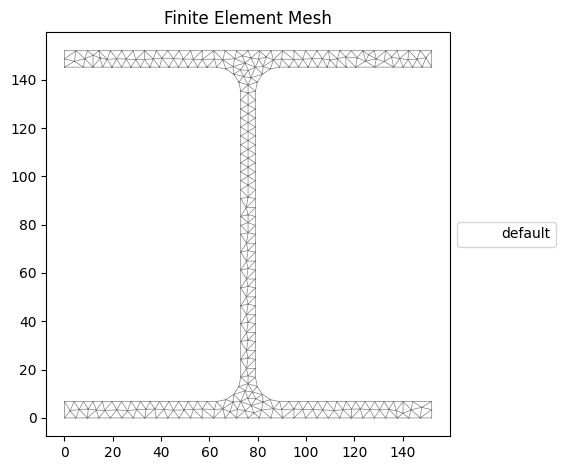

<Axes: title={'center': 'Finite Element Mesh'}>

In [ ]:
design_section.section.plot_mesh()

## Display Design Results

In [ ]:
for output in design_outputs:
  output.print_results()

-----------------------------------------------------------------
====================LOAD COMBO: 0.9G+Wu_X(+)=====================
-----------------------------------------------------------------
N*: 0.00kN
Mx*: 10.30kNm
My*: 0.00kNm
-----------------------------------------------------------------
governing_case: member_out_plane_capacity_ratio
governing_ratio: 0.26
design_status: PASS
============================CAPACITY=============================
Section Name: 150UC23.4
=========PURE MAJOR BENDING CAPACITY=========
length_eff_bending = 8500mm
compactness = NON_COMPACT
alpha_m = 2.25
Mo = 22.49kNm
alpha_s = 0.22
Zxp = 166723.75mm3
Zexp = 269121mm3
fMsxp = 77.51kNm
fMbxp = 39.08kNm
==========================DESIGN RATIOS==========================
===========SECTION CAPACITY RATIO============
N_section_capacity_ratio: 0.00
Mxp_section_capacity_ratio: 0.13
Myp_section_capacity_ratio: 0.00
biaxial_section_capacity_ratio: 0.13
============MEMBER CAPACITY RATIO============
member_axial

## Print Output File

In [ ]:
import sys

original_stdout = sys.stdout

with open("output.txt", "w") as f:
  sys.stdout = f
  for output in design_outputs:
    output.print_results()
  sys.stdout = original_stdout

# Calculation for Custom Section NOT USED

##Prepare Geometry and Run Solver

###Prepare Geometry

In [ ]:
from sectionproperties.analysis.section import Section
from sectionproperties.pre.library.steel_sections import i_section, circular_hollow_section, mono_i_section
from sectionproperties.pre.library.primitive_sections import rectangular_section, circular_section


#Section Parameter
bf = 178
h = 403
tf = 10.9
tw = 7.6
r = 11.4

# geometry = i_section(d=h, b=bf, t_f=tf, t_w=tw, r=r, n_r=5)
# geometry = circular_hollow_section(d=150, t=10, n=50)
geometry = mono_i_section(d=400, b_t=300, b_b=150, t_ft=11, t_fb=8, t_w=9, r=11, n_r=5)
# geometry = rectangular_section(b=200, d=400)
geometry = circular_section(d=20, n=10)
geometry.create_mesh(mesh_sizes=1)

geometry.plot_geometry()

### Sectionproperties Run Solver

In [ ]:
section = Section(geometry)
section.calculate_geometric_properties()
section.calculate_plastic_properties()
section.calculate_warping_properties()
section.display_results()
section.plot_mesh()

## Input Data

In [ ]:
##MATERIAL PROPERTIES
E = 200_000 #MPa
poissons_ratio = 0.3
fy = 320 #MPa
fu = 440 #MPa
density = 7850

In [ ]:
##SECTION PROPERTIES
area_holes = 0 #total area of holes for tension calculation
tension_config_case = TensionConfigCase.VI #options = Ia, Ib, IIa, IIb, III, IV, V, VI, VII from table 7.3.2 AS4100:1998, value=None -> kt=1

In [ ]:
##MEMBER PROPERTIES
rest_type = RestraintType.FF #restraint type
rotation_rest =  EndRotationalRestraint.NONE #rotational restraint at the member ends options: NONE, ONE, BOTH
d1 = d - 2*tf #clear distance between flanges
length = 12500
nw = 1 #number of web
gravity_load = True #whether the load is gravity load
load_height_top = False #location of the load at the top flange?
load_pos_end = False #is the load at the end?
cantilever = False #is cantilever?
moment_dist_type = 9 #from table 5.6.1 (1-10) if cantilever False, table 5.6.2 (1-3) if cantilever True. AS 4100:1998
beta_m = None #provide if cantilever False and moment_dist_type is 1,4,5,6, or 7. Otherwise leave as None
a = None #provide if cantilever False and moment_dist_type is 2 or 3. Otherwise leave as None

##for Compression
ke = 1.2 #AS4100:1998 cl.4.6.3
alpha_b = 0 #AS4100:1998 table 6.3.3

In [ ]:
##LOADING
N_str = -30 #kN #positive tension
Mx_str =10 #kNm
My_str = 0 #kNm

In [ ]:
##DESIGN
phi = 0.9

### Create Custom Local Buckling Plate(s)

In [ ]:
mat = SteelMaterial(name="Steel", elastic_modulus=E, poissons_ratio=poissons_ratio, yield_strength=fy, density=density*1e-3, fu=fu, color="teal")

In [ ]:
#make sure both plates_x and plates_y cover the whole sections

#major axis bending (x)

half_flange_x = Plate((bf-tw)/2, tf, mat, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.ONE, PlateStressType.UNIFORM)
web_x = Plate(h-2*tf, tw, mat, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.BOTH, PlateStressType.NON_UNIFORM)
plates_x = [half_flange_x, half_flange_x, half_flange_x, half_flange_x, web_x]

#minor axis bending (y)
half_flange_y = Plate((bf-tw)/2, tf, mat, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.ONE, PlateStressType.NON_UNIFORM)
web_y = Plate(h-2*tf, tw, mat, PlateType.FLAT, ResidualStressType.HR, PlateEdgeSupportType.BOTH, PlateStressType.UNIFORM)
plates_y = [half_flange_y, half_flange_y, half_flange_y, half_flange_y, web_y]

## Calculations

### Create Material

### Create Design Section

In [ ]:
material = mat
design_section = DesignSection(section, material, plates_x, plates_y, area_holes=area_holes, tension_config_case=tension_config_case)

### Create Design Member

In [ ]:
design_member = DesignMember(design_section, rest_type, rotation_rest, tf, tw, length, d1, nw=nw, gravity_load=gravity_load,
                             load_height_top=load_height_top, load_pos_end=load_pos_end, cantilever=cantilever, moment_dist_type=moment_dist_type, beta_m=beta_m, a=a, ke=ke, alpha_b=alpha_b)

### Loading Definition

In [ ]:
loads = UltimateLoads(N_str*1e3, Mx_str*1e6, My_str*1e6)

### Design

In [ ]:
design_output = LRFDSteelDesign(loads, design_member, phi)

## Display Design Results

In [ ]:
design_output.print_ratio()
print("-"*65)
print(f"Bending")
print(f"length_eff_bending = {design_member.length_eff:.0f}mm")
print(f"compactness = {design_member.design_section.local_buckling_x.compact_type}")
print(f"alpha_m = {design_member.alpha_m:.2f}")
print(f"alpha_s(+) = {design_member.alpha_s_pos:.2f}")
print(f"alpha_s(-) = {design_member.alpha_s_pos:.2f}")
print(f"Zx(+) = {design_member.design_section.Zx_pos:.2f}mm3")
print(f"Zx(-) = {design_member.design_section.Zx_neg:.2f}mm3")
print(f"Zex(+) = {design_member.design_section.Zex_pos:.0f}mm3")
print(f"Zex(-) = {design_member.design_section.Zex_neg:.0f}mm3")
print(f"Msx(+) = {design_member.design_section.Msx_pos/1e6:.2f}kNm")
print(f"Msx(-) = {design_member.design_section.Msx_neg/1e6:.2f}kNm")
print(f"Msy(+) = {design_member.design_section.Msy_pos/1e6:.2f}kNm")
print(f"Msy(-) = {design_member.design_section.Msy_neg/1e6:.2f}kNm")
print(f"Mbx(+) = {design_member.Mbx_pos/1e6:.2f}kNm")
print(f"Mbx(-) = {design_member.Mbx_neg/1e6:.2f}kNm")
print("-"*65)

print(f"Compression")
print(f"ke = {design_member.ke:.2f}")
print(f"length_eff_compression = {design_member.length_eff_comp:.0f}mm")
print(f"kf = {design_section.kf:.2f}")
print(f"lambda_n = {design_member.lambda_n_y:.0f}")
print(f"alpha_b = {design_member.alpha_b:.1f}")
print(f"alpha_c = {design_member.alpha_c_y:.3f}")
print(f"Ns = {design_section.Ns/1e3:.2f}kN")
print(f"Ncx = {design_member.Ncx/1e3:.2f}kN")
print(f"Ncy = {design_member.Ncy/1e3:.2f}kN")
print("-"*65)

print(f"Tension")
print(f"kt = {design_section.kt:.2f}")
print(f"Nt = {design_section.Nt:.2f}kN")